### Final Project

1. orientation
2. velocity

set body length to 1 unit, pool size about 1000x body size?

Notemigonus crysoleucas (golden shiner) and Gambusia holbrooki (mosquitofish)
cap the max velocity at like 50 cm/s so like 10 bodylength per seconds

visual latency is in the order of 10ms

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random as rng
from matplotlib import colors
import matplotlib as mpl
from svgpathtools import svg2paths
from svgpath2mpl import parse_path
import matplotlib.markers as mmarkers
import matplotlib.animation as animation
import matplotlib.cm as cm
import copy

Import fish svg

In [2]:
fih_path, attributes = svg2paths('fih.svg')
fmarker = parse_path(attributes[0]['d'])
fmarker.vertices -= fmarker.vertices.mean(axis=0)
fmarker = fmarker.transformed(mpl.transforms.Affine2D().scale(1,-1))
# plt.plot(1,1,marker = fmarker, markersize = 100)

Initialization

In [282]:
def initialize(numfish, maxcoord, maxvelocity = 10):
    N = numfish #number of fish
    maxvelocity = maxvelocity #bodylength per seconds

    #init coordinations
    motcoords = [np.array([rng.uniform(-maxcoord,maxcoord),rng.uniform(-maxcoord,maxcoord)]) for i in np.arange(N)]

    #init orientations
    radmotangles = [np.array(rng.uniform(0,2*np.pi)) for i in np.arange(N)]
    degmotangles = np.rad2deg(radmotangles)

    #initialize velocity magnitude array
    # motvelmag = np.zeros(N)
    
    #add initial velocities
    motvelmag = rng.normal(1,0.5,numfish)

    #create a velocity (direction & magnitude) array
    motvel = [np.array((motvelmag[i]*np.cos(radmotangles[i]),motvelmag[i]*np.sin(radmotangles[i]))) for i in np.arange(N)]
    return motcoords, radmotangles, motvelmag, motvel


Rule setting

In [265]:
#get distance to each neighbor
def finddistances(myindex, mycoord, coordarray):
    distances = [np.linalg.norm(np.subtract(mycoord, coordarray[i])) if i != myindex else np.nan for i in np.arange(len(coordarray))]
    return distances

#define crossproduct
def cross2d(a, b):
    return a[0] * b[1] - a[1] * b[0]

def findnearestneighbor(myindex, mycoord, coordarray):
    dist = finddistances(myindex, mycoord, coordarray)
    neighbor_index = np.nanargmin(dist)
    nearestdist = dist[np.nanargmin(dist)]
    return neighbor_index, nearestdist, dist

def findangletoneighbor(myorientation, mycoord, neighborcoord):
    myangle = myorientation #in radians
    myvector = (np.cos(myangle),np.sin(myangle))
    #get vector from me to you and normalize it
    vector_from_me_to_you = np.subtract(neighborcoord,mycoord)/np.linalg.norm(np.subtract(neighborcoord,mycoord))
    #calculate the dot product and the cross product
    dotproduct = np.dot(myvector, vector_from_me_to_you) 
    crossproduct = cross2d(myvector, vector_from_me_to_you)
    return dotproduct, crossproduct

#first find and index nearest neighbor
testcoord = (0,0)
coords = [(0,0), (1,0), (2,0), (0,3), (-4,3)]
findnearestneighbor(0, testcoord, coords)



(np.int64(1),
 np.float64(1.0),
 [nan, np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(5.0)])

In [291]:
def finddistancetonearestwall(mycoord, maxcoord):
    
    xdistance = np.subtract(np.abs(maxcoord), np.abs(mycoord[0]))
    ydistance = np.subtract(np.abs(maxcoord), np.abs(mycoord[1]))

    if mycoord[0] < 0:
        xdistance = -1*xdistance
    else: xdistance = xdistance
    if mycoord[1] < 0:
        ydistance = -1*ydistance
    else: ydistance = ydistance
    return xdistance, ydistance


def findangletowall(radmyorientation, mycoord, maxcoord):
    myangle = radmyorientation #in radians
    myvector = np.array([np.cos(myangle),np.sin(myangle)])

    #nearest walls
    xwall, ywall = finddistancetonearestwall(mycoord, maxcoord)

    if xwall != 0:
        xwallvector = np.array([1,0]) if xwall < 0 else np.array([-1,0])
    else: xwallvector = np.array([0,0])
    if ywall != 0:
        ywallvector = np.array([0,1]) if ywall < 0 else np.array([0,-1])
    else: ywallvector = np.array([0,0])
    
    #calculate the dot product and the cross product
    xdotproduct = np.dot(myvector, xwallvector) 
    ydotproduct = np.dot(myvector, ywallvector) 
    xcrossproduct = cross2d(myvector,xwallvector)
    ycrossproduct = cross2d(myvector,ywallvector)
    return xdotproduct, ydotproduct, xcrossproduct, ycrossproduct

coord = (-2,2)
arena = 10

finddistancetonearestwall(coord,arena/2)

(np.float64(-3.0), np.float64(3.0))

Test

[array([-4.34396644, -3.9705259 ])]
[181.30739423]
(np.float64(-0.6560335613510198), np.float64(-1.0294740963527573))
(np.float64(-0.9997396731155954), np.float64(-0.022816353756074645), np.float64(0.022816353756074645), np.float64(-0.9997396731155954))


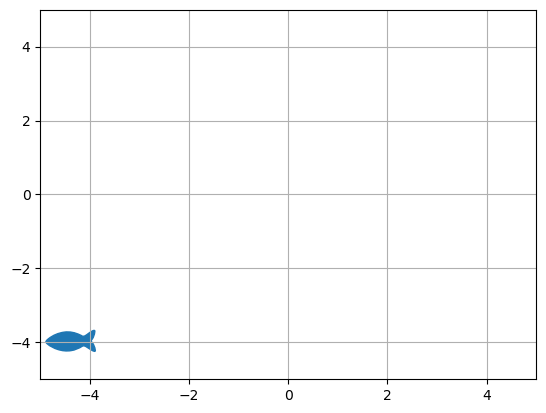

In [293]:
#test
poolsize = 10
N = 1
motcoords, radmotangles, motvelmag, motvel = initialize(N,poolsize/2)

xcoords, ycoords = zip(*motcoords)

degmotangles = np.rad2deg(radmotangles)

fig, ax = plt.subplots()
# scaling follows s = 160000/x^2 where x is the width of the coordinate
for i in np.arange(len(motcoords)):
    rotfmarker = fmarker.transformed(mpl.transforms.Affine2D().rotate_deg(degmotangles[i]))
    ax.scatter(xcoords[i],ycoords[i], marker = rotfmarker, s = 160000/poolsize**2)

ax.set_xlim(-poolsize/2,poolsize/2)
ax.set_ylim(-poolsize/2,poolsize/2)
ax.grid()
plt.plot()

print(motcoords)
print(degmotangles)

for i in np.arange(N):
    # print(findangletoneighbor(radmotangles[0], motcoords[0], motcoords[i]))
    print(finddistancetonearestwall(motcoords[0], poolsize/2))
    print(findangletowall(radmotangles[0],motcoords[0],poolsize/2))


- Radius of 1 body length = R 
- Speed: (front-back over side-side): This acceleration response was dependent on the fish’s current speed (multiply velocity by a factor)
- Attractive over R => accelerates/decelerates according to front or back
    - accelerate 1 bodylength based on the function cos(theta) where theta is the angle between the fish and its neighbor?
- Maybe some weight over front than back
- Repulsive inside R => accelerates/decelerates according to front or back
- Turn: (relative angle over distance)
- Turn towards neighbor’s position (30-60º rotation depending on relative angle)


In [273]:
#run this for all fish in one timestep
#we can also change the fish to only respond to a certain angle of neighbor, like -pi/3 to pi/3 rad
#error about 0.25 maybe, can change

def updatefish(positions,radorientations,speeds,velocity, arenasize = 100, time = 0, timestep = 0.1, maxa = 1.0, maxdwdt = 0.6, vdecay = 0.8, erroracc = 0.5, errordwdt = 0.5):
    copypositions = positions.copy()
    time += timestep
    t = timestep
    N = len(positions)
    maxspeed = 10
    minspeed = 0
    maxcoord = arenasize/2
    for i in np.arange(N):
        #find distance and angle to wall

        #first find the nearest neighbor
        neighindex, neighdist, dist = findnearestneighbor(i, copypositions[i], copypositions)
        #find its dotproduct
        dotproduct, crossproduct = findangletoneighbor(radorientations[i],copypositions[i],copypositions[neighindex]) #simply cos(theta) and sin(theta)

        #calculate the accelerations based on the dotproduct
        motacc = maxa*dotproduct + rng.uniform(-erroracc,erroracc)
        dwdt = maxdwdt*crossproduct + rng.uniform(-errordwdt,errordwdt)
        
        #Speed rule 1, attractve over R (2 body lengths) 
        if neighdist > 2:
            #update velocity magnitude based on where the other fish is. If in front, accelerate, if behind, deccelerate by a constant, let's say 0.5 bl/s^2. also fish only respond to the  60º in front
            if np.abs(speeds[i] + motacc*t) <= maxspeed:
                speeds[i] = speeds[i]*np.exp(-t/vdecay) + motacc*t 
            else:
                speeds[i] = speeds[i]*np.exp(-t/vdecay)
        #speed rule 2, repulsive under R
        elif neighdist < 2:
            #if behind, accelerate forward. if ahead, decelerate
            if np.abs(speeds[i] - motacc*t) <= maxspeed:
                speeds[i] = speeds[i]*np.exp(-t/vdecay) - motacc*t 
            else:
                speeds[i] = speeds[i]*np.exp(-t/vdecay)

        #orientation rule 1, turn towards nearest neighbor
        if neighdist > 2: #radpersecond
            radorientations[i] = radorientations[i] + dwdt*t
        elif neighdist < 2: #radpersecond
            radorientations[i] = radorientations[i] -  dwdt*t

        if neighdist > 2: #radpersecond
            radorientations[i] = radorientations[i] + dwdt*t
        elif neighdist < 2: #radpersecond
            radorientations[i] = radorientations[i] -  dwdt*t

        # #add repulsive force towards wall
        # xwalldist, ywalldist = finddistancetonearestwall(copypositions[i], maxcoord)
        # xwalldot, ywalldot = findangletowall(radorientations[i], copypositions[i], maxcoord)
        # if xwalldist < 2:
        
        #speed cannot be less than 0, fish cannot swim backwards
        if speeds[i] <= 0:
            speeds[i] = 0 
        
        #update velocity
        velocity[i] = (speeds[i]*np.cos(radorientations[i]),speeds[i]*np.sin(radorientations[i]))

        #update position 
        checknewposition = np.add(positions[i],np.array(velocity[i])*t)

        #check position so that it is within bounds
        positions[i] = positions[i] + np.array(velocity[i])*t # x = x+vt for all fish
        
    return positions, radorientations, speeds, velocity, time

fishpos = [(0,0), (5,5)]
spd = [0,0]
radfish = [0, 0]

print(updatefish(fishpos,radfish,spd,motvel))

([array([ 9.42039175e-03, -8.21388747e-05]), array([5., 5.])], [np.float64(-0.008719042203924788), np.float64(-0.1051945327121628)], [np.float64(0.09420749834821628), 0], [(np.float64(0.09420391746395668), np.float64(-0.0008213887467042374)), (np.float64(0.0), np.float64(-0.0))], 0.1)


Plot and analysis

In [274]:
#plotting function

def plot(coords, radorientations, arenasize, title = '', fishmarker = fmarker):
    degmotangles = np.rad2deg(radorientations)

    xcoords, ycoords = zip(*coords)
    N = len(coords)
    colors = cm.rainbow(np.linspace(0, 1, N))
    
    fig, ax = plt.subplots()
    # scaling follows s = 160000/x^2 where x is the width of the coordinate

    for i in np.arange(N):
        rotmarker = fishmarker.transformed(mpl.transforms.Affine2D().rotate_deg(degmotangles[i]))
        ax.scatter(xcoords[i],ycoords[i], marker = rotmarker, s = 160000/arenasize**2, color = colors[i])

    ax.set_xlim(-arenasize/2,arenasize/2)
    ax.set_ylim(-arenasize/2,arenasize/2)
    ax.set_title(title)
    ax.grid()
    plt.plot()

10


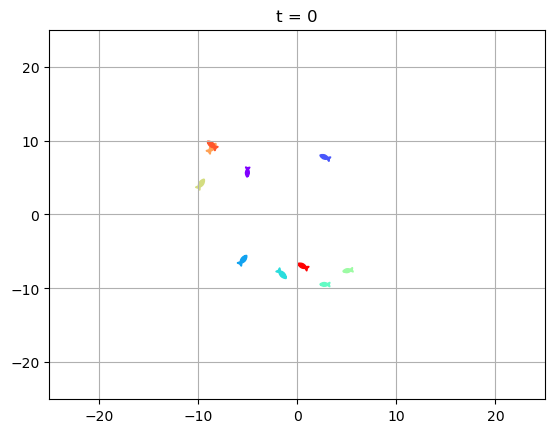

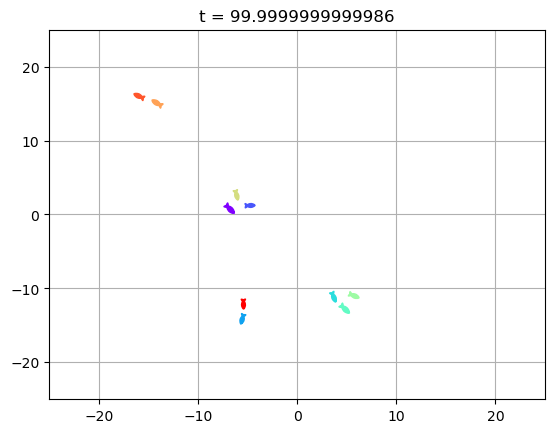

In [277]:
numiterations = 1000
poolsize = 100 #80 is the length of each side
numfish = 10
inittime = 0

positionarray = []

pos, motorientations, motspeeds, motvelocity = initialize(numfish,-10,10)
plot(pos,motorientations,poolsize/2, 't = 0')

for i in np.arange(numiterations):
    pos, motorientations, motspeeds, motvelocity, inittime = updatefish(pos, motorientations, motspeeds, motvelocity, time = inittime)
    positionarray.append(copy.deepcopy(pos))

plot(pos,motorientations,poolsize/2, f't = {inittime}')

print(len(motvelocity))


[]

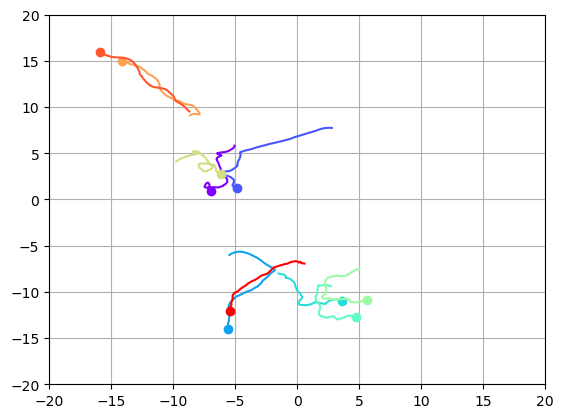

In [278]:
fig, ax = plt.subplots()

plotmaxcoord = 20
trajlength = 1000

colors = cm.rainbow(np.linspace(0, 1, numfish))

for n in np.arange(numfish):
    coordinates = []
    for i in np.arange(numiterations):
        coordinates.append(positionarray[i][n])
    fishcoordsx, fishcoordsy = zip(*coordinates)

    recent_x = fishcoordsx[-trajlength:]
    recent_y = fishcoordsy[-trajlength:] 

    ax.plot(recent_x, recent_y, color=colors[n])
    ax.plot(recent_x[-1], recent_y[-1], marker='o', color=colors[n])

ax.set_xlim(-plotmaxcoord,plotmaxcoord)
ax.set_ylim(-plotmaxcoord,plotmaxcoord)
ax.grid()
plt.plot()


In [ ]:
# fig, ax = plt.subplots()


# for i in np.arange(N):
#     fmarker = fmarker.transformed(mpl.transforms.Affine2D().rotate_deg(degmotangles[i]))
#     ax.scatter(xcoords[i],ycoords[i], marker = fmarker, s = 160000/poolsize**2)

# ax.set_xlim(0,poolsize)
# ax.set_ylim(0,poolsize)
# ax.grid()

# # title = ax.text(0.5,0.85, "", bbox={'facecolor':'w', 'alpha':0.5, 'pad':5},
# #                 transform=ax.transAxes, ha="center")

# totaliter = 500

# # Use consistent variable name and properly update the lattice
# for i in range(totaliter):
#     for i in range(current_lattice.size):
#         current_lattice = metrosimcompact(current_lattice)  # Update properly
#     arrayoflat.append(current_lattice.copy())  # Store a copy

# def animatefunc(frame):
#     nextlat = arrayoflat[frame]
#     im.set_array(nextlat)
#     title.set_text(f'Frame: {frame}')
#     return im,

# ani = animation.FuncAnimation(fig, animatefunc, frames=totalsweeps, interval=10, blit=True)
# ani.save('newnewising.gif', writer='pillow')
# print('done')

Analysis